# [VAE in Pyro](http://pyro.ai/examples/vae.html#VAE-in-Pyro)

Let’s see how we implement a VAE in Pyro. The dataset we’re going to model is MNIST, a collection of images of handwritten digits. Since this is a popular benchmark dataset, we can make use of PyTorch’s convenient data loader functionalities to reduce the amount of boilerplate code we need to write:

In [5]:
import torchvision
import torchvision.transforms as T
#from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

In [9]:
import pyro
import pyro.distributions as dist
import torch

In [8]:
from pyro.contrib.examples.util import MNIST

In [4]:
import os

In [1]:
pixel_path = os.path.join(os.environ['HOME']+'/mnist/')

In [2]:
if not os.path.exists(pixel_path):
    os.mkdir(pixel_path)

In [6]:
trans = T.ToTensor()

In [10]:
train_set = MNIST(root=pixel_path, train=True, transform=trans, download=False)
test_set = MNIST(root=pixel_path, train=False, transform=trans)

The main thing to draw attention to here is that we use transforms.ToTensor() to normalize the pixel intensities to the range [0, 1].

In [11]:
use_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': use_cuda}

In [12]:
train_dl = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
test_dl = DataLoader(dataset=test_set, batch_size=128, shuffle=True, **kwargs)

In [13]:
x11 = train_set[11][0]

In [14]:
x11.shape

torch.Size([1, 28, 28])

In [15]:
x11.reshape(-1)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [16]:
import matplotlib.pyplot as plt

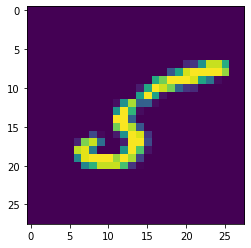

In [17]:
plt.imshow(x11[0])

In [ ]:
x11.reshape(-1).shape

torch.Size([784])

___

## VAE

In [18]:
import torch.nn as nn

In [19]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, out_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc2(hidden))
        return loc_img

In [20]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, self.input_dim)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [21]:
encoder = Encoder(784, 400, 50)
decoder = Decoder(50, 400, 784)

Given an image  the forward call of Encoder returns a mean and covariance that together parameterize a (diagonal) Gaussian distribution in latent space.

In [32]:
class VAE(nn.Module):
    def __init__(self, input_dim = 784, hidden_dim = 400, z_dim = 50, out_dim = 784, use_cuda = False) -> None:
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, out_dim)

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.input_dim = input_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            #p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            #we use new_zeros and new_ones to ensure that newly created tensors are on the same GPU device.
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample code from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # use of .to_event(1) when sampling from the latent z - this ensures that instead of 
            # treating our sample as being generated from a univariate normal with batch_size = z_dim, 
            # we treat them as being generated from a multivariate normal distribution with diagonal covariance. 
            # As such, the log probabilities along each dimension is summed out when we evaluate .log_prob for 
            # a “latent” sample.
            loc_img = self.decoder(z)
            pyro.sample(
                        "obs", 
                        dist.Bernoulli(loc_img, validate_args=False).to_event(1), 
                        obs=x.reshape(-1, self.input_dim)
                    ) 

    
    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))



    def reconstruct(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        return loc_img


The point we’d like to make here is that the two Modules encoder and decoder are attributes of VAE (which itself inherits from nn.Module). This has the consequence they are both automatically registered as belonging to the VAE module. So, for example, when we call parameters() on an instance of VAE, PyTorch will know to return all the relevant parameters. It also means that if we’re running on a GPU, the call to cuda() will move all the parameters of all the (sub)modules into GPU memory.

___

In [33]:
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

In [63]:
LR = 1.0e-3
USE_CUDA = False
NUM_EPOCKS = 1
TEST_FREQUENCY = 5
NUM_EPOCHS = 20

In [64]:
pyro.clear_param_store()

In [65]:
vae = VAE(use_cuda=USE_CUDA)

In [66]:
adam_args = {"lr": LR}
optimizer = Adam(adam_args)

In [67]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [68]:
train_elbo = []
test_elbo = []

In [69]:
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0

    for x, _ in train_dl:
        epoch_loss += svi.step(x)
    normalizer_train = len(train_dl.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train

    train_elbo.append(total_epoch_loss_train)
    print(
        "[epoch %03d] average training loss: %.4f"
        % (epoch, total_epoch_loss_train)
    )

    if epoch % TEST_FREQUENCY == 0:
        test_loss = 0.0
        for x, _ in test_dl:
            test_loss += svi.evaluate_loss(x)
        
        normalizer_test = len(test_dl.dataset)
        total_epoch_loss_test = test_loss / normalizer_test
        test_elbo.append(total_epoch_loss_test)
        print(
        "[epoch %03d] average test loss: %.4f"
        % (epoch, total_epoch_loss_test)
        )    

[epoch 000] average training loss: 175.0518
[epoch 000] average test loss: 144.3839
[epoch 001] average training loss: 135.3278
[epoch 002] average training loss: 122.8843
[epoch 003] average training loss: 116.7019
[epoch 004] average training loss: 113.2523
[epoch 005] average training loss: 111.1673
[epoch 005] average test loss: 109.4239
[epoch 006] average training loss: 109.7319
[epoch 007] average training loss: 108.7318
[epoch 008] average training loss: 107.9758
[epoch 009] average training loss: 107.3218
[epoch 010] average training loss: 106.8242
[epoch 010] average test loss: 106.1790
[epoch 011] average training loss: 106.3823
[epoch 012] average training loss: 106.0532
[epoch 013] average training loss: 105.7557
[epoch 014] average training loss: 105.4534
[epoch 015] average training loss: 105.2472
[epoch 015] average test loss: 104.6097
[epoch 016] average training loss: 105.0143
[epoch 017] average training loss: 104.8596
[epoch 018] average training loss: 104.6433
[epo

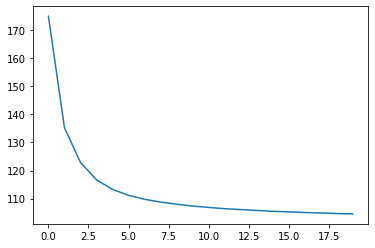

In [70]:
plt.plot(train_elbo)

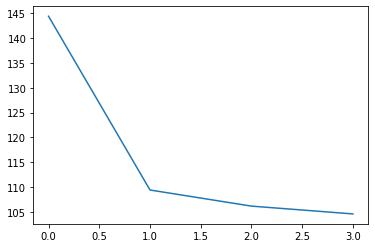

In [71]:
plt.plot(test_elbo)

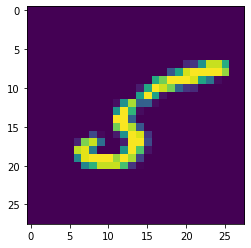

In [77]:
plt.imshow(x11[0])

In [72]:
reconstruct_image = vae.reconstruct(x11)

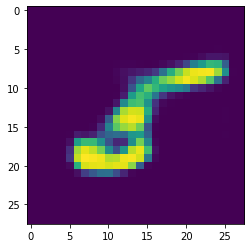

In [75]:
plt.imshow(reconstruct_image.detach().numpy().reshape(28,28))

___

In [79]:
data = test_dl.dataset.data.float()

In [81]:
data.size()

torch.Size([10000, 28, 28])

In [83]:
labels = test_dl.dataset.targets

In [84]:
labels.size()

torch.Size([10000])

In [93]:
classes = labels.detach().numpy()

In [99]:
classes.shape

(10000,)

In [85]:
z_loc, z_scale = vae.encoder(data)

In [86]:
z_loc.size()

torch.Size([10000, 50])

In [96]:
import matplotlib
import numpy as np
matplotlib.use("Agg")
from sklearn.manifold import TSNE

In [90]:
model_tsne = TSNE(n_components=2, random_state=3)

In [91]:
z__states = z_loc.detach().numpy()

In [92]:
z_embed = model_tsne.fit_transform(z__states)

/home/dulunche/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dulunche/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [100]:
fig = plt.figure(figsize=(12,10))

for ic in range(10):
    

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 864x720 with 0 Axes>